In [1]:
!pip uninstall torch -y
!pip uninstall torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

!curl -s https://course.fast.ai/setup/colab | bash
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Uninstalling torch-1.4.0:
  Successfully uninstalled torch-1.4.0
Uninstalling torchvision-0.5.0:
  Successfully uninstalled torchvision-0.5.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/90/6141bf41f5655c78e24f40f710fdd4f8a8aff6c8b7c6f0328240f649bdbe/torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl
Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'course-v3-master/'

Mounted at /content/gdrive


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=6c092e10f4fd8f30613e3a17834d8ef44eefa3a1c7bb4506c5452cd75ea9e4b1
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [0]:
# set kaggle json dir
import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My \Drive/fastai-v3/.kaggle/"

In [0]:
os.environ['KAGGLE_USERNAME'] = "thesergiu"
os.environ['KAGGLE_KEY'] = "6c620f6d90d570bfefa62244878f57d7"

In [11]:
import os
!pwd
os.chdir('/content/gdrive/My Drive/course-v3-master/PlantPathology')
!pwd

/content
/content/gdrive/My Drive/course-v3-master/PlantPathology


In [0]:
#kaggle competitions download -c plant-pathology-2020-fgvc7


In [0]:
#unzipping the zip files and deleting the zip files
#!unzip plant-pathology-2020-fgvc7

In [12]:
!pwd
#os.chdir('course-v3-master/test/')
os.chdir('test/')
!pwd



/content/gdrive/My Drive/course-v3-master/PlantPathology
/content/gdrive/My Drive/course-v3-master/PlantPathology/test


In [0]:
#should be in test directory - the one that contains images and train.csv
!pwd
from csv import reader

def create_row(old_row):
  row_data = {}
  row_data['image_id'] = old_row['image_id']
  if old_row['healthy'] == '1':
    row_data['class'] = 'healthy'
  elif old_row['multiple_diseases'] == '1':
    row_data['class'] = 'multiple_diseases'
  elif old_row['rust'] == '1':
    row_data['class'] = 'rust'
  elif old_row['scab'] == '1':
    row_data['class'] = 'scab'
  return row_data

def create_file(file_name):
  with open(file_name, 'w') as new_file:
    writer = csv.DictWriter(new_file, fieldnames=['image_id', 'class'])
    with open('train.csv') as old_file:
      for row in csv.DictReader(old_file):
        writer.writerow(create_row(row))

create_file('train_parsed.csv')

In [0]:
data = ImageDataBunch.from_csv(path=base_dir + "/PlantPathology/test/", folder="images", csv_labels="train_parsed.csv",
                               suffix='.jpg', ds_tfms=get_transforms(), size=244, bs=32).normalize(imagenet_stats)
                                

In [15]:
print(data.classes)
print(data.c)

['healthy', 'multiple_diseases', 'rust', 'scab']
4


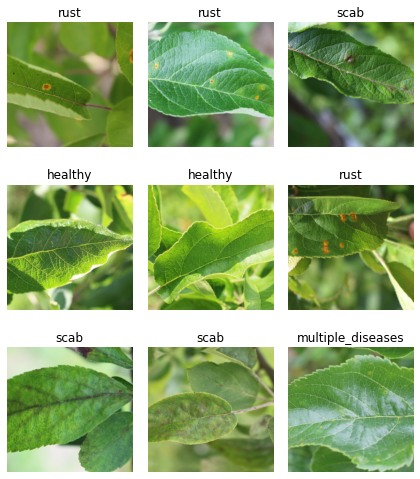

In [16]:
data.show_batch(rows=3, figsize=(6,7))


In [17]:
learn = cnn_learner(data, models.resnet152, metrics=error_rate, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [18]:
# make sure we have a gpu to train on and see which one it is
import torch
print(torch.__version__)
print(torch.cuda.device(0))
torch.cuda.empty_cache()
torch.cuda.is_available()

use_cuda = True
print(torch.cuda.is_available())

1.4.0
True


In [19]:

!nvidia-smi

Sat May 16 11:55:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    28W /  70W |   1049MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [20]:

learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.984320,0.659499,0.137363,08:12
1,0.685384,0.623362,0.145604,02:38
2,0.476536,0.363801,0.107143,02:41
3,0.342593,0.348010,0.090659,02:37
4,0.279591,0.295868,0.076923,02:37
5,0.219590,0.294417,0.071429,02:37


In [0]:
learn.save('stage-1')

In [0]:
learn.freeze()

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
losses,indexes = interp.top_losses()

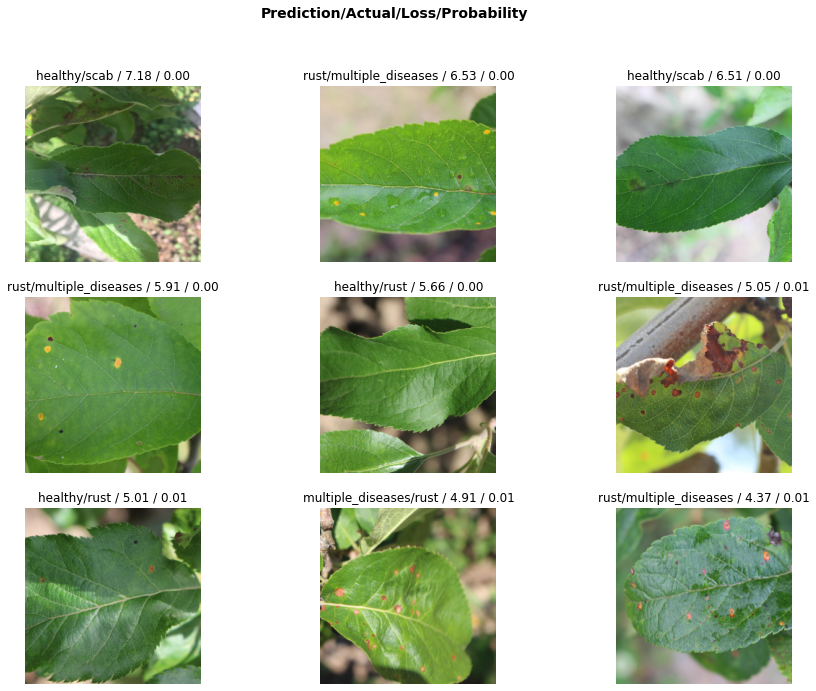

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

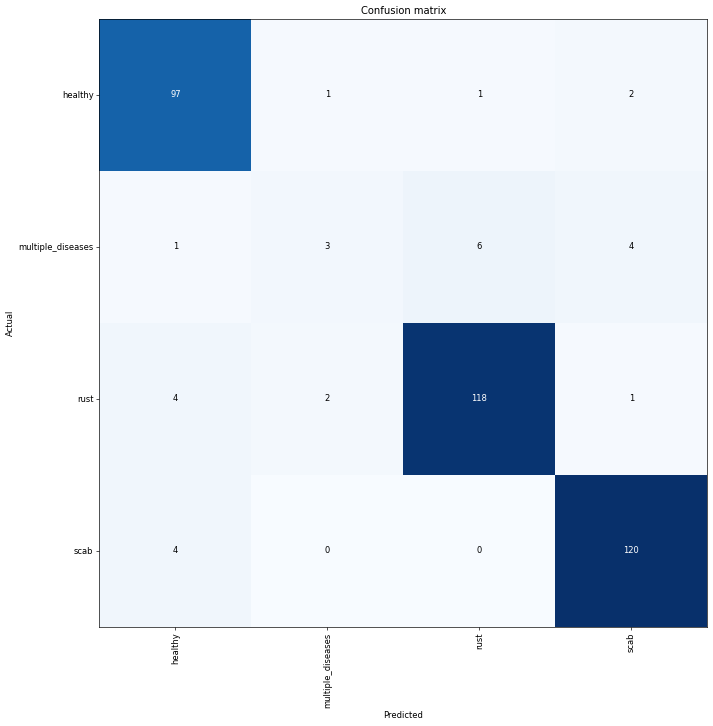

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


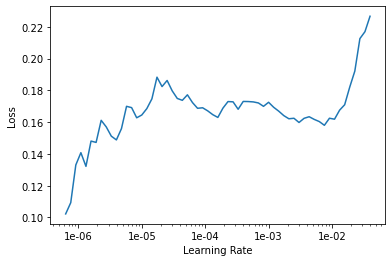

In [58]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.190483,0.296744,0.068681,02:42


In [31]:
learn.fit_one_cycle(3, max_lr=slice(1e-5, 1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.177545,0.285324,0.071429,02:42
1,0.196198,0.272925,0.068681,02:42
2,0.178540,0.280159,0.068681,02:42


In [0]:
learn.save('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


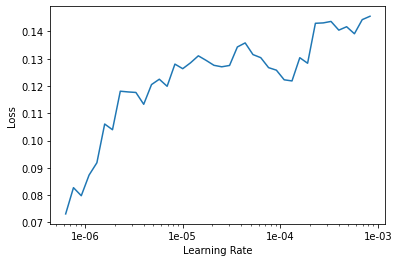

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (1456 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
healthy,rust,healthy,healthy,multiple_diseases
Path: /content/gdrive/My Drive/course-v3-master/PlantPathology/test;

Valid: LabelList (364 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
rust,rust,healthy,scab,scab
Path: /content/gdrive/My Drive/course-v3-master/PlantPathology/test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride

In [35]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4, 3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.182332,0.233015,0.063187,02:40
1,0.172095,0.251575,0.063187,02:42


KeyboardInterrupt: ignored

In [0]:
learn.freeze()
learn.save('stage-3')

In [48]:
learn.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (1456 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
healthy,rust,healthy,healthy,multiple_diseases
Path: /content/gdrive/My Drive/course-v3-master/PlantPathology/test;

Valid: LabelList (364 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
rust,rust,healthy,scab,scab
Path: /content/gdrive/My Drive/course-v3-master/PlantPathology/test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


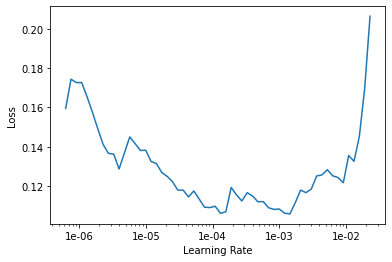

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(1, max_lr=slice(5e-6, 1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.110075,0.195833,0.060440,02:32


In [0]:
learn.freeze()
learn.save('stage-4')

In [59]:
learn.load('stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (1456 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
healthy,rust,healthy,healthy,multiple_diseases
Path: /content/gdrive/My Drive/course-v3-master/PlantPathology/test;

Valid: LabelList (364 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
rust,rust,healthy,scab,scab
Path: /content/gdrive/My Drive/course-v3-master/PlantPathology/test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


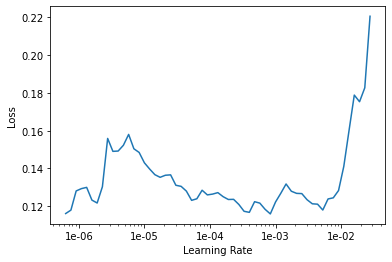

In [60]:
learn.lr_find()
learn.recorder.plot()

In [62]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(8e-5, 8e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.086807,0.166057,0.052198,02:38


In [0]:
learn.freeze()
learn.save('stage-5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


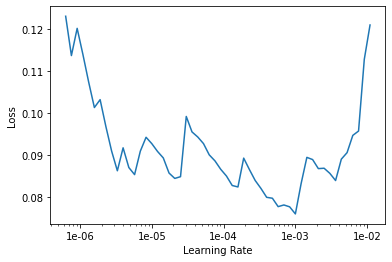

In [65]:
learn.lr_find()
learn.recorder.plot()

In [66]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(2e-6, 1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.060067,0.164433,0.046703,02:34


In [0]:
learn.freeze()
learn.save('stage-6')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


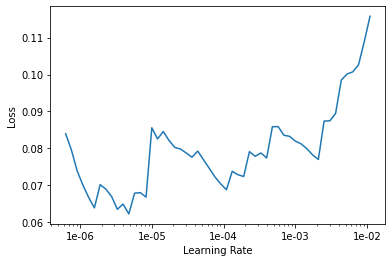

In [70]:
learn.lr_find()
learn.recorder.plot()

In [74]:
learn.load('stage-6')

Learner(data=ImageDataBunch;

Train: LabelList (1456 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
healthy,rust,healthy,healthy,multiple_diseases
Path: /content/gdrive/My Drive/course-v3-master/PlantPathology/test;

Valid: LabelList (364 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
rust,rust,healthy,scab,scab
Path: /content/gdrive/My Drive/course-v3-master/PlantPathology/test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride

In [0]:
learn.export()

In [0]:
learn = load_learner('/content/gdrive/My Drive/course-v3-master/PlantPathology/test')

In [83]:
#%cd /content/gdrive/My Drive/fastai-v3/plant_pathology
#!rm output.csv
!pwd
#os.chdir('course-v3-master/PlantPathology/test/')
#!pwd

print_interval = 50
classes = ['healthy', 'multiple_diseases', 'rust', 'scab']
base_path = '/content/gdrive/My Drive/course-v3-master/PlantPathology/test/images/'

def get_predictions(image_id, image_number):
  predicted_class,_,probabilities = learn.predict(open_image(base_path + image_id + '.jpg'))
  output_dict = {}
  output_dict["image_id"] = image_id
  for idx,clazz in enumerate(classes):
    # add prediction value for each class with 10 digits
    output_dict[clazz] = '{:.10f}'.format(probabilities.numpy()[idx])
  # document progress every [print_interval]th image
  if image_number % print_interval == 0:
    print(image_id + " - " + str(predicted_class) + ' - ' + str(probabilities.numpy()))

  return output_dict

def create_output_csv(input_csv, output_csv):
  with open(output_csv, 'w') as output:
    writer = csv.DictWriter(output, fieldnames=['image_id'] + classes)
    writer.writeheader()
    with open(input_csv) as input:
      # add row for each image with predictions
      for idx,(row) in enumerate(csv.DictReader(input)):
        writer.writerow(get_predictions(row['image_id'], idx))

create_output_csv('test.csv', 'output.csv')

/content/gdrive/My Drive/course-v3-master/PlantPathology/test
Test_0 - rust - [2.492262e-08 6.080585e-04 9.993919e-01 6.187541e-09]
Test_50 - rust - [3.570694e-07 2.389962e-03 9.976095e-01 1.317355e-07]
Test_100 - scab - [1.072571e-05 6.174383e-05 1.361110e-07 9.999274e-01]
Test_150 - scab - [0.240654 0.028415 0.028453 0.702479]
Test_200 - rust - [6.954941e-06 5.552278e-05 9.999374e-01 1.402570e-07]
Test_250 - healthy - [9.998172e-01 8.024216e-05 8.428519e-05 1.838600e-05]
Test_300 - scab - [0.101209 0.048191 0.099728 0.750871]
Test_350 - scab - [1.509150e-04 7.928464e-04 5.521847e-06 9.990507e-01]
Test_400 - rust - [1.682238e-05 2.510714e-02 9.748752e-01 7.724755e-07]
Test_450 - rust - [6.457603e-04 6.890558e-04 9.986597e-01 5.494844e-06]
Test_500 - rust - [1.604387e-05 8.289477e-05 9.999009e-01 1.136633e-07]
Test_550 - scab - [1.590646e-02 4.737874e-03 2.067684e-07 9.793554e-01]
Test_600 - rust - [1.714717e-07 3.440663e-02 9.655932e-01 4.733780e-08]
Test_650 - rust - [1.388960e-08 8.